In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
tesla = pd.read_csv('TSLA.csv', index_col="Date", parse_dates=True)

In [3]:
tesla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,62.400002,64.421997,62.200001,64.106003,64.106003,21761000
2018-01-03,64.199997,65.050003,63.110001,63.450001,63.450001,22607500
2018-01-04,62.574001,63.709999,61.136002,62.924000,62.924000,49731500
2018-01-05,63.324001,63.448002,62.400002,63.316002,63.316002,22956000
2018-01-08,63.200001,67.403999,63.099998,67.281998,67.281998,49297000


In [4]:
tesla = tesla.resample('B').bfill()

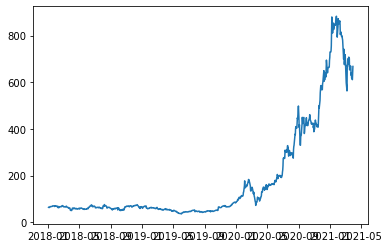

In [5]:
#Check to see if the data is stationary
plt.plot(tesla.index, tesla.Close)

Looks like tesla stock price did not start gaining momentum until January 2020. Therefore, we will forcast the stock price based on the data from January 2020 till date.

In [6]:
tesla = tesla.loc['2020':]['Close']

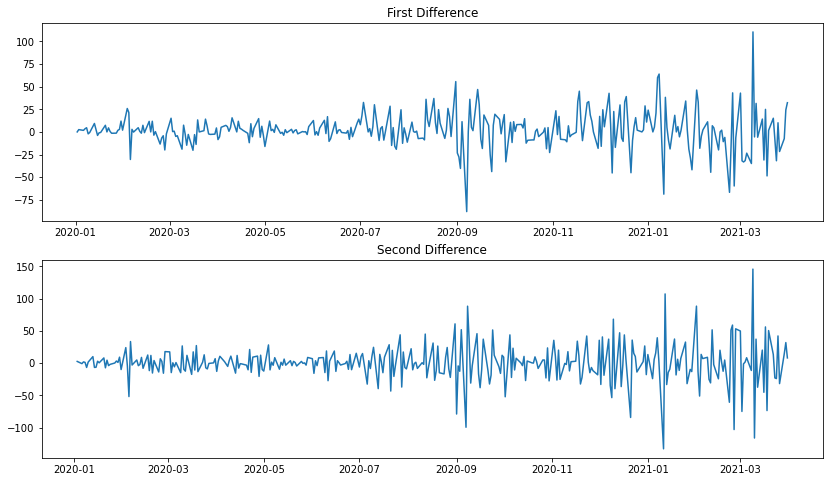

In [7]:
#The data is not stationary, therefore I'll take the first and second difference
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8))
ax1.plot(tesla.index, tesla.diff())
ax1.title.set_text('First Difference')
ax2.plot(tesla.index, tesla.diff().diff())
ax2.title.set_text('Second Difference')

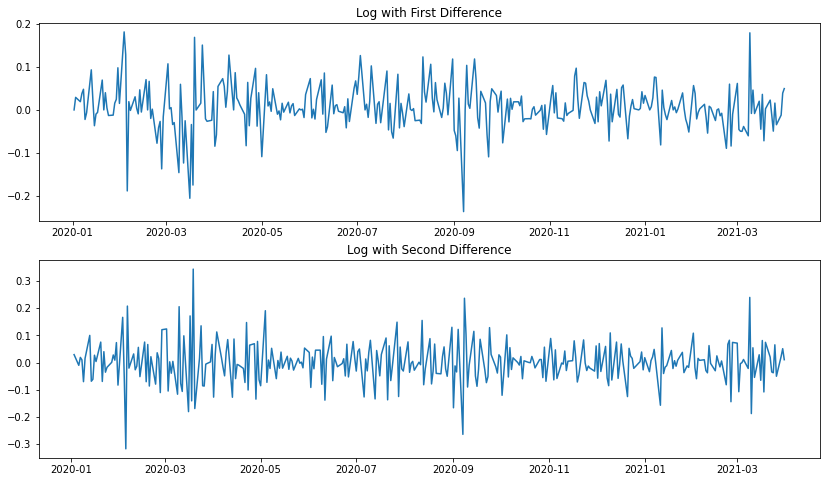

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8))
ax1.plot(tesla.index, np.log(tesla).diff())
ax1.title.set_text('Log with First Difference')
ax2.plot(tesla.index, np.log(tesla).diff().diff())
ax2.title.set_text('Log with Second Difference')

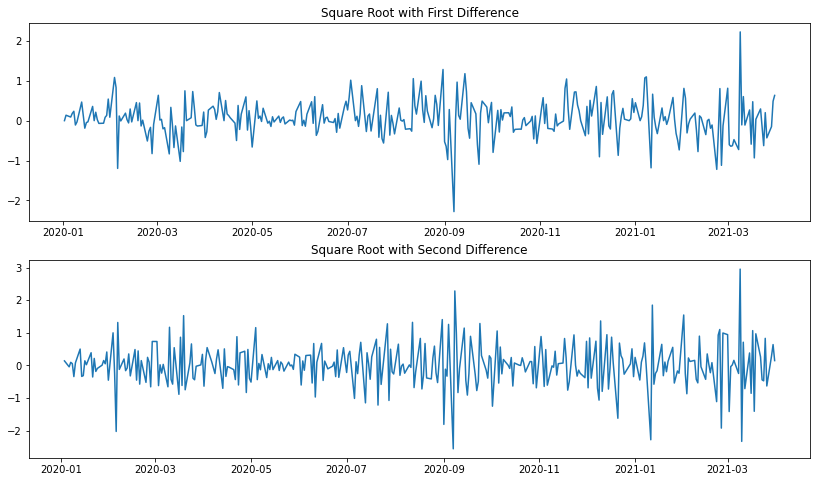

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8))
ax1.plot(tesla.index, np.sqrt(tesla).diff())
ax1.title.set_text('Square Root with First Difference')
ax2.plot(tesla.index, np.sqrt(tesla).diff().diff())
ax2.title.set_text('Square Root with Second Difference')

The graph above looks stationary, however, I will used the Augmented Dicky-Fuller test to confirm my hypothesis.

- **Null Hypotheis**: The time series has a unit root, meaning it is is not stationary
- **Alternate Hypothesis**: The time series does not have a unit root, meaning it is stationary

In [10]:
#Note that the transformed tesla data will be denoted at tesla_t
tesla_t = tesla.diff().diff().dropna()

In [11]:
result = adfuller(tesla_t)

In [12]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.060000
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


The test statistic value of the time series is -29. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -29 is less than the value of -3.438 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Also, since the p-value is less than 0.05, we can confidently reject the null hypothesis.

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

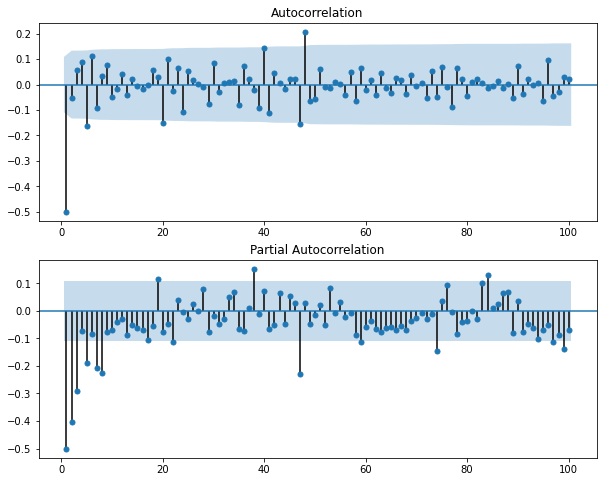

In [13]:
# Create Figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Make ACF Plot
plot_acf(tesla_t, lags=100, zero=False, ax=ax1)

# Make PACF Plot
plot_pacf(tesla_t, lags=100, zero=False, ax=ax2)

plt.show()

In [50]:
model = SARIMAX(tesla, order=(0, 2, 3))
results = model.fit()

In [51]:
mean_prediction = results.get_prediction(start = '2021-01-04', end='2021-03-31', dynamic=False).predicted_mean
forecast = results.get_forecast(steps=30, dynamic=False)

In [52]:
confidence_interval = forecast.conf_int()
mean_forecast = forecast.predicted_mean

mean_prediction = np.exp(mean_prediction)
mean_forecast = np.exp(mean_forecast)
confidence_interval = np.exp(confidence_interval)

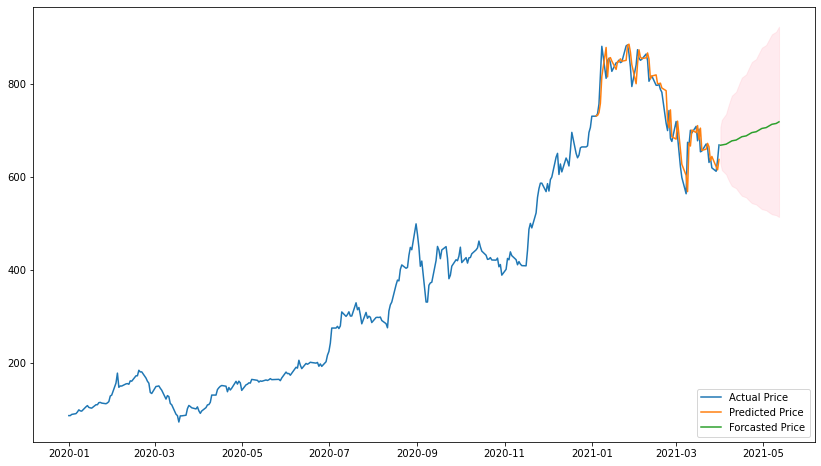

In [53]:
plt.figure(figsize=(14, 8))
plt.plot(tesla)
plt.plot(mean_prediction)
plt.plot(mean_forecast)
plt.fill_between(confidence_interval.index, confidence_interval['lower Close'], confidence_interval['upper Close'], alpha=0.3, color='pink')
plt.legend(['Actual Price', 'Predicted Price', 'Forcasted Price'], loc='lower right')

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  326
Model:             SARIMAX(20, 2, 10)   Log Likelihood               -1414.593
Date:                Thu, 01 Apr 2021   AIC                           2891.186
Time:                        18:42:54   BIC                           3008.389
Sample:                    01-01-2020   HQIC                          2937.967
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2290      0.611     -2.013      0.044      -2.426      -0.032
ar.L2         -1.3801      0.889     -1.552      0.121      -3.123       0.363
ar.L3         -1.9020      0.812     -2.343      0.019      -3.493      -0.311
ar.L4         -1.9288      0.986     -1.956      0.050      -3.861       0.004
ar.L5         -1.7955      1.261     -1.424      0.154      -4.267       0.676
ar.L6         -1.6412      0.938     -1.749      0.080      -3.480       0.198
ar.L7         -1.2905      0.750     -1.720      0.086      -2.761       0.180
ar.L8         -0.9363      0.784     -1.194      0.233      -2.474       0.601
ar.L9         -0.3461      0.534     -0.648      0.517      -1.393       0.701
ar.L10         0.0768      0.287      0.268      0.789      -0.485       0.639
ar.L11         0.1670      0.298      0.560      0.575      -0.417       0.751
ar.L12         0.2810      0.313      0.898      0.369      -0.332       0.894
ar.L13         0.2465      0.324      0.760      0.447      -0.389       0.882
ar.L14         0.2763      0.327      0.845      0.398      -0.364       0.917
ar.L15         0.2711      0.301      0.901      0.367      -0.318       0.860
ar.L16         0.2317      0.277      0.835      0.404      -0.312       0.775
ar.L17         0.1987      0.270      0.737      0.461      -0.330       0.727
ar.L18         0.1351      0.213      0.636      0.525      -0.282       0.552
ar.L19         0.0789      0.168      0.471      0.638      -0.250       0.408
ar.L20        -0.0666      0.115     -0.580      0.562      -0.292       0.159
ma.L1          0.1900      0.619      0.307      0.759      -1.023       1.403
ma.L2          0.1183      0.549      0.216      0.829      -0.957       1.193
ma.L3          0.6086      0.487      1.250      0.211      -0.345       1.563
ma.L4          0.0876      0.624      0.140      0.888      -1.134       1.310
ma.L5         -0.2954      0.724     -0.408      0.683      -1.714       1.124
ma.L6         -0.0983      0.770     -0.128      0.898      -1.608       1.411
ma.L7         -0.3651      0.611     -0.598      0.550      -1.562       0.831
ma.L8         -0.3811      0.462     -0.825      0.409      -1.286       0.524
ma.L9         -0.4708      0.489     -0.963      0.336      -1.429       0.488
ma.L10        -0.3901      0.473     -0.824      0.410      -1.318       0.537
sigma2       354.8607    102.455      3.464      0.001     154.052     555.669
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               301.97
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               8.94   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

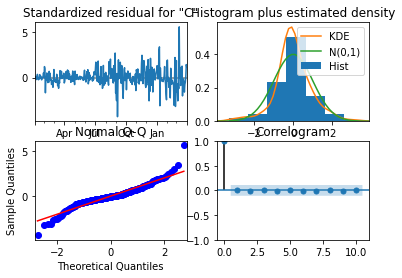

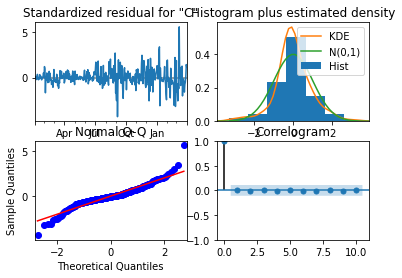

In [37]:
results.plot_diagnostics()